In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [155]:
# Load dataset
df = pd.read_csv("../data/SuperstoreData.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [156]:
# View column names
df.columns.tolist()

# Check for missing values
df.isnull().sum()

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [157]:
# Fix data types (Order Date & Ship Date)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y', errors='coerce')
df['Order Date']  
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y', errors='coerce')
df['Ship Date']

0      2016-11-11
1      2016-11-11
2      2016-06-16
3      2015-10-18
4      2015-10-18
          ...    
9989   2014-01-23
9990   2017-03-03
9991   2017-03-03
9992   2017-03-03
9993   2017-05-09
Name: Ship Date, Length: 9994, dtype: datetime64[ns]

In [158]:
print(df.dtypes) # Check current data types
# print(df[["Sales", "Profit", "Discount", "Quantity"]].describe())  # Summary stats

# Data cleaning steps before numeric conversion
for col in ["Sales", "Profit", "Discount", "Quantity"]:
    if col in df.columns:
        # Remove any non-numeric characters if needed (like $, %, commas)
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace('[^\d.]', '', regex=True)
            
        # Convert empty strings to NaN
        df[col] = df[col].replace('', pd.NA)

# Then your numeric conversion code
for col in ["Sales", "Profit", "Discount", "Quantity"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.dtypes)

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object
Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     o

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_13368\370555440.py:9: SyntaxWarning: invalid escape sequence '\d'
  df[col] = df[col].astype(str).str.replace('[^\d.]', '', regex=True)


In [159]:
# Summary statistics for numeric columns
print("\nSummary statistics:\n", df.describe())


Summary statistics:
             Row ID                     Order Date  \
count  9994.000000                           9994   
mean   4997.500000  2016-04-30 00:07:12.259355648   
min       1.000000            2014-01-03 00:00:00   
25%    2499.250000            2015-05-23 00:00:00   
50%    4997.500000            2016-06-26 00:00:00   
75%    7495.750000            2017-05-14 00:00:00   
max    9994.000000            2017-12-30 00:00:00   
std    2885.163629                            NaN   

                           Ship Date   Postal Code         Sales     Quantity  \
count                           9994   9994.000000   9994.000000  9994.000000   
mean   2016-05-03 23:06:58.571142912  55190.379428    229.858001     3.789574   
min              2014-01-07 00:00:00   1040.000000      0.444000     1.000000   
25%              2015-05-27 00:00:00  23223.000000     17.280000     2.000000   
50%              2016-06-29 00:00:00  56430.500000     54.490000     3.000000   
75%           

In [160]:
# Check for negative profits
neg_profits = df[df['Profit'] < 0]
neg_profits.shape[0]

1871

In [161]:
# Drop rows missing critical fields
df_cleaned = df.dropna(subset=['Order Date', 'Sales']).copy()
df_cleaned

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [162]:
# Use first day of month (Timestamp) for plotting
df_cleaned["YearMonth"] = (df_cleaned["Order Date"].dt.to_period("M").dt.to_timestamp())


<br><br><br><br>__Critical Analysis__

In [163]:
# Monthly sales trend
monthly_sales = (
    df_cleaned.groupby("YearMonth", as_index=False)["Sales"]
    .sum()
    .sort_values("YearMonth")
)
monthly_sales

# Top 10 customers by sales
top_customers = (
    df_cleaned.groupby("Customer Name", as_index=False)["Sales"]
    .sum()
    .sort_values("Sales", ascending=False)
    .head(10)
)

# Average profit vs discount
profit_vs_discount = (
    df_cleaned.groupby("Discount", as_index=False)["Profit"]
    .mean()
    .sort_values("Discount")
)

# Region performance
region_perf = (
    df_cleaned.groupby("Region", as_index=False)[["Sales", "Profit"]]
    .sum()
    .sort_values("Sales", ascending=False)
)

# Loss-making orders by category
loss_orders = (
    df_cleaned[df_cleaned["Profit"] < 0]
    .groupby("Category", as_index=False)["Profit"]
    .count()
    .rename(columns={"Profit": "Loss Orders"})
    .sort_values("Loss Orders", ascending=False)
)

__#Visualisation__

__Deeper EDA__<br>
<br>_Sales by Category_<br>
<br>_Check sales trends over time (monthly/yearly)_<br>
<br>_Identify top customers/products_<br>
<br>_Look at profit vs discountS_<br>
<br>_Region-wise and segment-wise performance_<br>
<br>_Spot loss-making areas (negative profit)_<br>

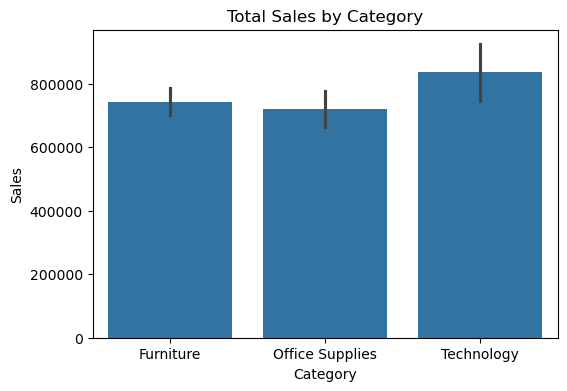

In [164]:
# Sales by Category
plt.figure(figsize=(6,4))
sns.barplot(x='Category', y='Sales', data=df, estimator=sum)
plt.title('Total Sales by Category')
plt.show()

In [165]:
# Monthly Sales Trend
plt.figure(figsize=(8, 5))
plt.plot(monthly_sales["YearMonth"], monthly_sales["Sales"])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.savefig("../outputs/monthly_sales_trend.png")
plt.close()


# Top 10 Customers
plt.figure(figsize=(8, 5))
plt.barh(top_customers["Customer Name"], top_customers["Sales"])
plt.gca().invert_yaxis()
plt.title("Top 10 Customers by Sales")
plt.xlabel("Total Sales")
plt.ylabel("Customer Name")
plt.tight_layout()
plt.savefig("../outputs/top_customers.png")
plt.close()


# Average Profit vs Discount
plt.figure(figsize=(8, 5))
plt.plot(profit_vs_discount["Discount"], profit_vs_discount["Profit"], marker="o")
plt.title("Average Profit vs Discount")
plt.xlabel("Discount")
plt.ylabel("Average Profit")
plt.tight_layout()
plt.savefig("../outputs/profit_vs_discount.png")
plt.close()


# Region Sales
plt.figure(figsize=(8, 5))
plt.bar(region_perf["Region"], region_perf["Sales"])
plt.title("Total Sales by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.savefig("../outputs/region_sales.png")
plt.close()

In [166]:
#Export clean tables for Power BI / SQL
monthly_sales.to_csv("../data/monthly_sales.csv", index=False)
top_customers.to_csv("../data/top_customers.csv", index=False)
profit_vs_discount.to_csv("../data/profit_vs_discount.csv", index=False)
region_perf.to_csv("../data/region_performance.csv", index=False)
loss_orders.to_csv("../data/loss_orders.csv", index=False)

In [167]:

conn = sqlite3.connect("../sql/superstore.db")

# Load your cleaned dataframe into SQL
df_cleaned.to_sql("orders", conn, if_exists="replace", index=False)




9994